In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

In [2]:
Cosmo = namedtuple('Cosmo', ['h0', 'om0', 'l0', 'omt'])
sedpyFilter = namedtuple('sedpyFilter', ['name', 'wavelengths', 'transmission'])
BaseTemplate = namedtuple('BaseTemplate', ['name', 'flux'])
Observation = namedtuple('Observation', ['num', 'AB_fluxes', 'AB_f_errors', 'z_spec'])
DustLaw = namedtuple('DustLaw', ['name', 'EBV', 'transmission'])

In [3]:
conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue.json' # attention à la localisation du fichier !
with open(conf_json, "r") as inpfile:
    inputs = json.load(inpfile)

#cosmo = Cosmology.make_jcosmo(inputs['Cosmology']['h0'])
cosmo = Cosmo(inputs['Cosmology']['h0'], inputs['Cosmology']['om0'], inputs['Cosmology']['l0'],\
              inputs['Cosmology']['om0']+inputs['Cosmology']['l0'])

z_grid = jnp.arange(inputs['Z_GRID']['z_min'],\
                    inputs['Z_GRID']['z_max']+inputs['Z_GRID']['z_step'],\
                    inputs['Z_GRID']['z_step'])

fine_z_grid = jnp.arange(inputs['Z_GRID']['z_min'],\
                         inputs['Z_GRID']['z_max']+0.05,\
                         0.05)

wl_grid = jnp.arange(inputs['WL_GRID']['lambda_min'],\
                     inputs['WL_GRID']['lambda_max']+inputs['WL_GRID']['lambda_step'],\
                     inputs['WL_GRID']['lambda_step'])

print("Loading filters :")
filters_dict = inputs['Filters']
filters_arr = tuple( sedpyFilter(*Filter.load_filt(filters_dict[ident]["name"],\
                                                   filters_dict[ident]["path"],\
                                                   filters_dict[ident]["transmission"]\
                                                  )\
                                )
                    for ident in tqdm(filters_dict) )
N_FILT = len(filters_arr)

print("Building templates :")
templates_dict = inputs['Templates']
baseTemp_arr = tuple( BaseTemplate(*Template.make_base_template(templates_dict[ident]["name"],\
                                                                templates_dict[ident]["path"],\
                                                                wl_grid
                                                               )\
                                  )
                     for ident in tqdm(templates_dict) )

#baseFluxes_arr = jnp.row_stack((bt.flux for bt in baseTemp_arr))

print("Generating dust attenuations laws :")
extlaws_dict = inputs['Extinctions']
dust_arr = []
for ident in tqdm(extlaws_dict):
    dust_arr.extend([ DustLaw(extlaws_dict[ident]['name'],\
                                 ebv,\
                                 Extinction.load_extinc(f'{ident}_{ebv}',\
                                                        extlaws_dict[ident]['path'],\
                                                        ebv,\
                                                        wl_grid)\
                                )\
                        for ebv in tqdm(inputs['e_BV'])\
                       ])

#extlaws_arr = jnp.row_stack( (dustlaw.transmission for dustlaw in dust_arr) )

print("Loading observations :")
data_path = os.path.abspath(inputs['Dataset']['path'])
data_ismag = (inputs['Dataset']['type'].lower() == 'm')

data_file_arr = np.loadtxt(data_path)
_obs_arr = []

for i in tqdm(range(data_file_arr.shape[0])):
    try:
        assert (len(data_file_arr[i,:]) == 1+2*N_FILT) or (len(data_file_arr[i,:]) == 1+2*N_FILT+1), f"At least one filter is missing in datapoint {data_file_arr[i,0]} : length is {len(data_file_arr[i,:])}, {1+2*N_FILT} values expected.\nDatapoint removed from dataset."
        #print(int(data_file_arr[i, 0]))
        if (len(data_file_arr[i,:]) == 1+2*N_FILT+1):
            observ = Observation(int(data_file_arr[i, 0]),\
                                 *Galaxy.load_galaxy(data_file_arr[i, 1:2*N_FILT+1],\
                                                     data_ismag),\
                                 data_file_arr[i, 2*N_FILT+1]\
                                )
        else:
            observ = Observation(int(data_file_arr[i, 0]),\
                                 *Galaxy.load_galaxy(data_file_arr[i, 1:2*N_FILT+1],\
                                                     data_ismag),\
                                 None\
                                )
        #print(observ.num)
        _obs_arr.extend([observ])
    except AssertionError:
        pass

Loading filters :


100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


Building templates :


100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1598.35it/s]


In [4]:
df_res = pd.read_pickle(f"{inputs['run name']}_results.pkl")

In [5]:
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2
1992,0.21,0.3513,AVG_CLUST_CWW_Im,Prevot,0.40,80.860563
2267,0.93,0.8467,CWW_Im-id699,Prevot,0.25,99.401578
16434,0.65,0.6667,AVG_CLUST_CWW_E,Calzetti,0.05,15.823902
7468,0.33,2.9230,CWW_Scd-id585,Calzetti,0.00,37.719133
15278,0.41,0.5025,CWW_Im-id699,Calzetti,0.40,37.295159
...,...,...,...,...,...,...
16742,0.45,0.4930,AVG_CLUST_CWW_E,Prevot,0.10,11.362419
8281,0.37,0.4798,AVG_CLUST_CWW_E,Calzetti,0.00,43.353141
6677,2.57,0.0779,CWW_Im-id699,Calzetti,0.35,75.494314
16029,0.49,1.0070,CWW_Sbc-id496,Prevot,0.50,26.257716


In [6]:
for obs in tqdm(_obs_arr):
    for i,filt in enumerate(filters_arr):
        if obs.num in df_res.index:
            df_res.loc[obs.num, f"MagAB({filt.name})"] = -2.5*jnp.log10(obs.AB_fluxes[i])-48.6
            df_res.loc[obs.num, f"err_MagAB({filt.name})"] = 1.086*obs.AB_f_errors[i]/obs.AB_fluxes[i]

100%|██████████| 1000/1000 [00:19<00:00, 50.33it/s]


In [7]:
df_res['bias'] = df_res['Photometric redshift']-df_res['True redshift']
df_res['std'] = df_res['bias']/(1.+df_res['True redshift'])
df_res['Outlier'] = np.abs(df_res['std'])>0.15
outl_rate = 100.0*len(df_res[df_res['Outlier']])/len(df_res)
print(f'Outlier rate = {outl_rate}%')

Outlier rate = 18.42374616171955%


In [8]:
df_res['G-R'] = df_res['MagAB(hsc_gHSC)']-df_res['MagAB(hsc_rHSC)']
df_res['I-Z'] = df_res['MagAB(hsc_iHSC)']-df_res['MagAB(hsc_zHSC)']
df_res['redness'] = df_res['G-R']/df_res['I-Z']
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,MagAB(cosmos_u_cfht),err_MagAB(cosmos_u_cfht),MagAB(cosmos_u_new),err_MagAB(cosmos_u_new),...,MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,std,Outlier,G-R,I-Z,redness
1992,0.21,0.3513,AVG_CLUST_CWW_Im,Prevot,0.40,80.860563,23.597939,0.009011,23.590080,0.009618,...,21.389137,0.005900,21.398636,0.007631,-0.1413,-0.104566,False,0.832497,0.343040,2.426818
2267,0.93,0.8467,CWW_Im-id699,Prevot,0.25,99.401578,22.657005,0.003464,22.664528,0.003893,...,21.359421,0.005737,21.449127,0.007586,0.0833,0.045107,False,0.300827,0.298538,1.007667
16434,0.65,0.6667,AVG_CLUST_CWW_E,Calzetti,0.05,15.823902,25.711151,0.046798,25.697212,0.060749,...,21.095779,0.004608,20.794853,0.004721,-0.0167,-0.010020,False,1.574532,0.445000,3.538276
7468,0.33,2.9230,CWW_Scd-id585,Calzetti,0.00,37.719133,27.349693,0.179366,27.288322,0.278177,...,24.927147,0.042578,24.659279,0.060273,-2.5930,-0.660974,True,0.773018,0.032463,23.812221
15278,0.41,0.5025,CWW_Im-id699,Calzetti,0.40,37.295159,23.216331,0.005780,23.164589,0.006905,...,21.787415,0.006524,21.603737,0.007499,-0.0925,-0.061564,False,0.769615,0.085861,8.963480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16742,0.45,0.4930,AVG_CLUST_CWW_E,Prevot,0.10,11.362419,25.108955,0.038098,25.376991,0.058832,...,20.258728,0.003549,20.047401,0.003757,-0.0430,-0.028801,False,1.651642,0.355240,4.649371
8281,0.37,0.4798,AVG_CLUST_CWW_E,Calzetti,0.00,43.353141,23.853546,0.010192,23.962303,0.021159,...,19.869591,0.002885,19.719177,0.003066,-0.1098,-0.074199,False,1.472702,0.280479,5.250660
6677,2.57,0.0779,CWW_Im-id699,Calzetti,0.35,75.494314,21.889168,0.002691,22.032242,0.005249,...,20.624390,0.005032,20.542320,0.005844,2.4921,2.311996,True,0.257629,0.039406,6.537851
16029,0.49,1.0070,CWW_Sbc-id496,Prevot,0.50,26.257716,26.049728,0.059824,25.906891,0.088872,...,22.706642,0.010585,22.405815,0.012264,-0.5170,-0.257598,True,1.088203,0.567451,1.917703


<AxesSubplot:xlabel='G-R', ylabel='I-Z'>

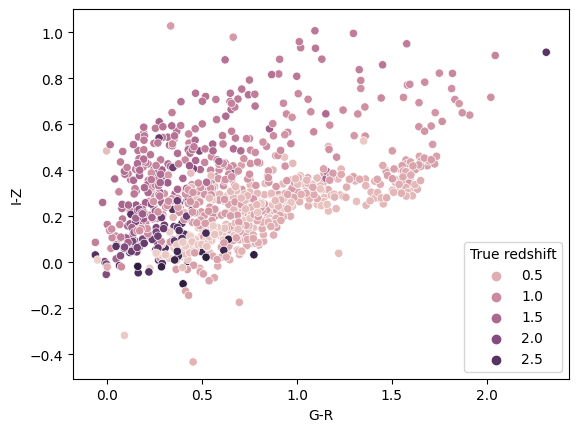

In [9]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='G-R', y='I-Z', hue='True redshift', ax=a)

<AxesSubplot:xlabel='G-R', ylabel='I-Z'>

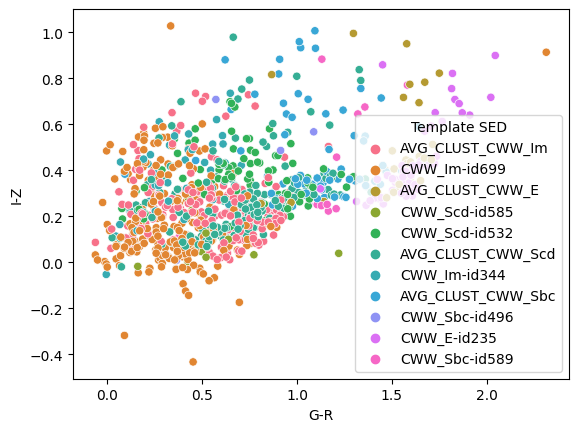

In [10]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='G-R', y='I-Z', hue='Template SED', ax=a)

Text(0.5, 1.0, 'EmuLP on COSMOS2020 subset, prior=True, Outliers rate=18.424%')

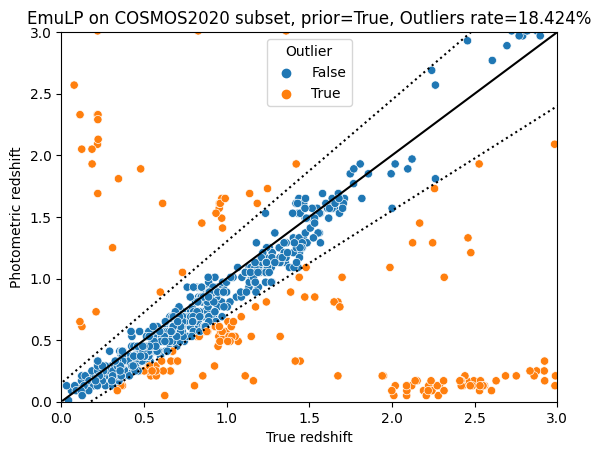

In [11]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='True redshift', y='Photometric redshift', hue='Outlier', ax=a)
a.plot(z_grid, z_grid, c='k')
a.plot(z_grid, z_grid+0.15*(1+z_grid), c='k', ls=':')
a.plot(z_grid, z_grid-0.15*(1+z_grid), c='k', ls=':')
a.set_xlim(0.,3.0)
a.set_ylim(0.,3.0)
a.set_title(f"EmuLP on COSMOS2020 subset, prior={inputs['prior']}, Outliers rate={outl_rate:.3f}%")

In [12]:
with open(f"{inputs['run name']}_results_dicts.pkl", 'rb') as handle:
    results_dict=pickle.load(handle)

In [13]:
keys = [key for key in results_dict.keys()]
_ex_=keys[0]
zps=z_grid

In [14]:
key_0=_ex_
_dict_0=results_dict[key_0]
_dict_0

DeviceArray([[[  240.36708,   175.73778,   179.82124, ...,  7078.449  ,
                6604.3125 ,  6180.5234 ],
              [  242.78236,   279.1588 ,   343.04532, ...,  5218.592  ,
                4762.1025 ,  4365.8354 ],
              [  389.66357,   507.99667,   621.4271 , ...,  3454.3667 ,
                3072.1929 ,  2754.0046 ],
              ...,
              [ 1434.0538 ,  1667.55   ,  1847.1338 , ...,  5784.6465 ,
                5891.0176 ,  5999.6025 ],
              [ 1733.599  ,  1971.7139 ,  2155.409  , ...,  6641.571  ,
                6732.389  ,  6828.3877 ],
              [ 2352.1826 ,  2580.9277 ,  2762.3142 , ...,  8045.437  ,
                8121.8647 ,  8207.012  ]],

             [[  759.32794,   958.83673,  1150.5677 , ...,  4379.2896 ,
                4036.8633 ,  3758.1409 ],
              [ 1060.6191 ,  1300.5282 ,  1516.9028 , ...,  2587.0215 ,
                2315.8667 ,  2109.469  ],
              [ 1416.4236 ,  1680.3556 ,  1911.6008 , ...,  1300.38

In [15]:
_zps = np.array([])
chi2s = np.array([])
modids = np.array([])
extlaws = np.array([])
ebvs = np.array([])

for i,mod in enumerate(baseTemp_arr):
    for j, dust in enumerate(dust_arr):
        _zps = np.append(_zps, fine_z_grid)
        #f_interp = interp1d(z_grid, _dict_0[i, j, :], kind='cubic', bounds_error=False, fill_value="extrapolate")
        f_interp = j_spline(z_grid, _dict_0[i, j, :], k=3)
        _interp_chis = f_interp(fine_z_grid) # np.interp(fine_z_grid, z_grid, _dict_0[i, j, :])
        chi2s = np.append(chi2s, _interp_chis)
        modids = np.append(modids, np.full(fine_z_grid.shape, mod.name))
        extlaws = np.append(extlaws, np.full(fine_z_grid.shape, dust.name))
        ebvs = np.append(ebvs, np.full(fine_z_grid.shape, dust.EBV))

dict_0 = {}
dict_0['zp'] = _zps
dict_0['chi2'] = chi2s
dict_0['mod id'] = modids
dict_0['ext law'] = extlaws
dict_0['eBV'] = ebvs

In [16]:
df0 = pd.DataFrame(dict_0)
df0

,zp,chi2,mod id,ext law,eBV
0,0.01,240.367081,AVG_CLUST_CWW_Sbc,Calzetti,0.0
1,0.06,174.119049,AVG_CLUST_CWW_Sbc,Calzetti,0.0
2,0.11,180.521988,AVG_CLUST_CWW_Sbc,Calzetti,0.0
3,0.16,196.996277,AVG_CLUST_CWW_Sbc,Calzetti,0.0
4,0.21,259.673492,AVG_CLUST_CWW_Sbc,Calzetti,0.0
...,...,...,...,...,...
14635,2.81,9441.269531,CWW_Scd-id585,Prevot,0.5
14636,2.86,9415.628906,CWW_Scd-id585,Prevot,0.5
14637,2.91,9342.344727,CWW_Scd-id585,Prevot,0.5
14638,2.96,9312.465820,CWW_Scd-id585,Prevot,0.5


<AxesSubplot:xlabel='zp', ylabel='chi2'>

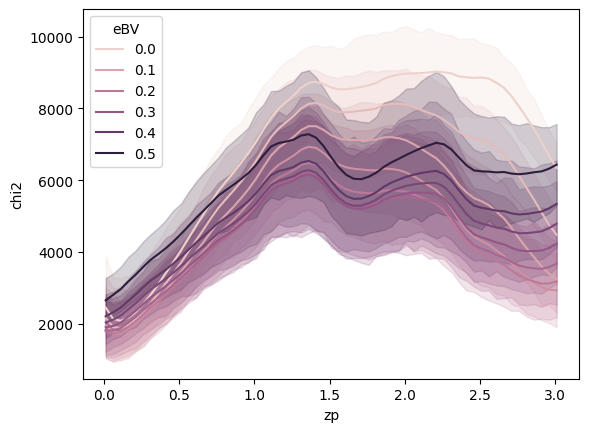

In [17]:
sns.lineplot(data=df0, x='zp', y='chi2', hue='eBV')

In [18]:
_sel = (df0['mod id']==df_res.loc[key_0,'Template SED']) * (df0['ext law']==df_res.loc[key_0,'Extinction law'])
df00 = df0[_sel]
df000 = df00[df00['chi2']<1000000]

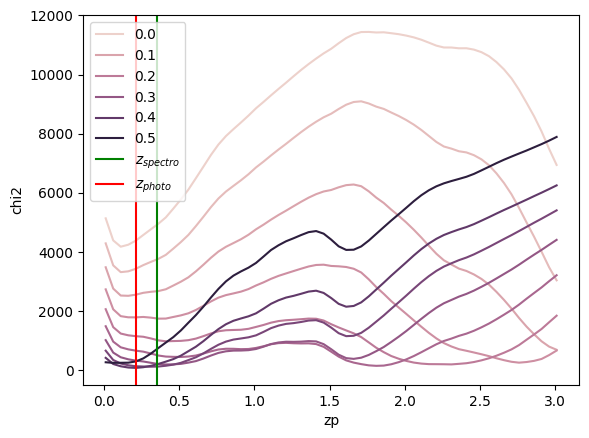

In [19]:
f,a = plt.subplots(1,1)
sns.lineplot(data=df000, x='zp', y='chi2', hue='eBV', ax=a)
a.axvline(df_res.loc[key_0, 'True redshift'], c='green', label="$z_{spectro}$")
a.axvline(df_res.loc[key_0, 'Photometric redshift'], c='red', label="$z_{photo}$")
a.legend()

/tmp/ipykernel_17952/3019878046.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(fine_z_grid, p_arr_mod[:,0]/np.trapz(p_arr_mod[:,0], fine_z_grid))


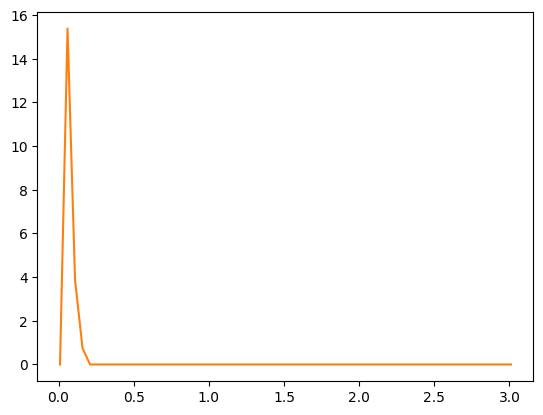

In [20]:
chi_arr_mod = np.column_stack([df00[df00['eBV']==val]['chi2'].values\
                               for val in np.unique(df00['eBV'].values)]) # if 'CWW' in mod])
p_arr_mod = np.exp(-0.5*chi_arr_mod)
plt.plot(fine_z_grid, p_arr_mod[:,0]/np.trapz(p_arr_mod[:,0], fine_z_grid))
plt.plot(fine_z_grid, p_arr_mod[:,-1]/np.trapz(p_arr_mod[:,-1], fine_z_grid))

In [21]:
p_arr_mod.shape

(61, 10)

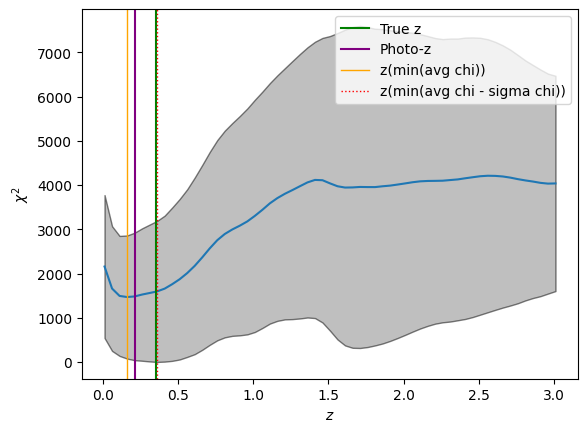

In [22]:
f,a = plt.subplots(1,1)
chi_avg = np.average(chi_arr_mod, axis=1)
chi_std = np.std(chi_arr_mod, axis=1)
a.plot(fine_z_grid, chi_avg)
a.fill_between(x=fine_z_grid, y1=np.fmax(np.ones_like(chi_avg), chi_avg-chi_std), y2=chi_avg+chi_std, alpha=0.5, facecolor='grey', edgecolor='k')
a.axvline(df_res.loc[key_0, 'True redshift'], label='True z', c='g')
a.axvline(df_res.loc[key_0, 'Photometric redshift'], label='Photo-z', c='purple')
a.axvline(fine_z_grid[np.nanargmin(chi_avg)], label='z(min(avg chi))', c='orange', lw=1)
a.axvline(fine_z_grid[np.nanargmin(chi_avg-chi_std)], label='z(min(avg chi - sigma chi))', c='red', lw=1, ls=':')
a.set_xlabel('$z$')
a.set_ylabel('$\chi^2$')
a.legend()

OK donc c'est pas complètement sans espoir ! Il faudrait intégrer la visualisation de ces résultats dans un dash maintenant...

In [23]:
if False:
    df_temp_prop = pd.read_pickle('COSMOS2020-with-FORS2-HSC_only-jaxcosmo_templates_properties.pkl')
    df_temp_prop

In [24]:
if False:
    np.power(10., -0.4*(df_temp_prop.loc[0,'Mag(cosmos_u_new)'] +48.6))

Smail distribution : $n(z) = z^{a}\mathrm{e}^{-\left(\frac{z}{z_0}\right)^{b}}$

In [25]:
smail_z1 = jc.redshift.smail_nz(1., 2.,  1., zmax=3.) # a=1, b=2, z0=1

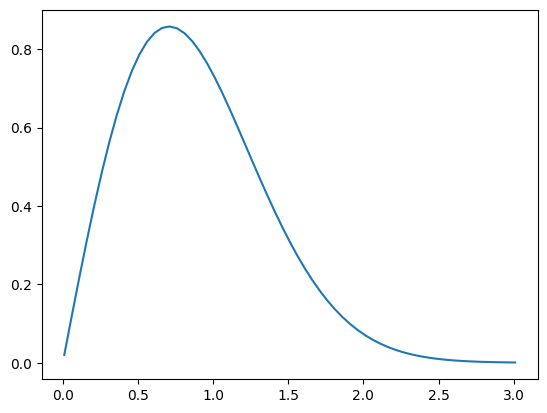

In [26]:
plt.plot(fine_z_grid, smail_z1(fine_z_grid))

In [27]:
np.trapz(smail_z1(zps), zps)

0.99964

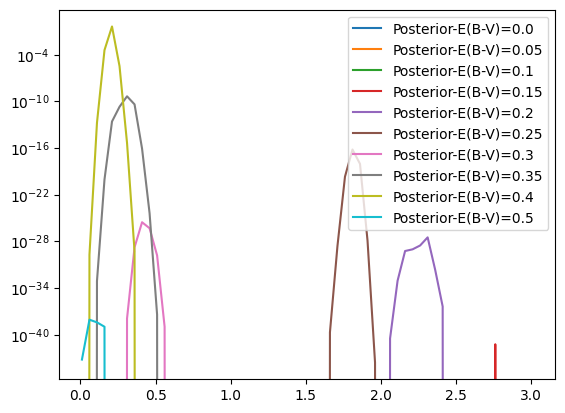

In [28]:
chimin=jnp.nanmin(jnp.array(df000['chi2']))
for val in np.unique(df000['eBV']):
    _sel = (df000['eBV'] == val)
    prior = smail_z1(jnp.array(df000['zp'][_sel]))
    newchi = jnp.array(df000['chi2'][_sel]-chimin)-2*jnp.log(prior)
    dist = jnp.exp(-0.5*newchi)
    norm = jnp.trapz(dist, jnp.array(df000['zp'][_sel]))
    plt.plot(df000['zp'][_sel], dist, label=f"Posterior-E(B-V)={val}")
plt.legend()
plt.yscale('log')

## LEPHARE prior on N(z)
Based on [z-VVDS](https://cesam.lam.fr/vvds/)

### Construct the filters

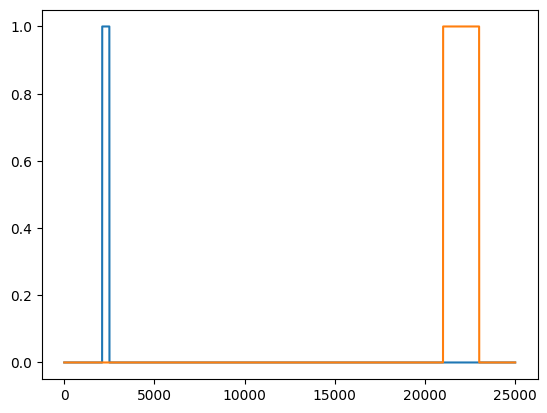

In [29]:
# NUV
nuv_transm = np.zeros_like(wl_grid)
nuv_transm[(wl_grid>=2100.)*(wl_grid<=2500.0)] = 1.0
NUV_filt = sedpyFilter("NUV", wl_grid, nuv_transm)

# NIR
nir_transm = np.zeros_like(wl_grid)
nir_transm[(wl_grid>=21000.)*(wl_grid<=23000.0)] = 1.0
NIR_filt = sedpyFilter("NIR", wl_grid, nir_transm)

plt.plot(wl_grid, nuv_transm)
plt.plot(wl_grid, nir_transm)

### Define the NUV-R rest-frame color corrected for dust-extinction

In [30]:
basetempl = [ bt for bt in baseTemp_arr if bt.name == df_res.loc[key_0,'Template SED'] ][0]
extlaw = [ dust for dust in dust_arr if (dust.name == df_res.loc[key_0, 'Extinction law'])\
                                          and (dust.EBV == df_res.loc[key_0, 'E(B-V)']) ][0]
                
obs = [ _obs for _obs in _obs_arr if _obs.num == key_0 ][0]
lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                        wl_grid, basetempl.flux*extlaw.transmission)\
                          for filt in (NUV_filt, NIR_filt)])
#nuv_nir_fluxes = jnp.power(10, -0.4*(nuv_nir_mags+48.6))
#lnuv, lnir = jnp.log10(nuv_nir_fluxes)
nuvk = lnuv-lnir #-2.5*(lnuv-lnir)
nuvk

DeviceArray(3.965128, dtype=float32)

### Define the prior in function of nuvk and Mag(i)
Pb : qui est 'red'? - c'est le redshift de la SED.

In [31]:
def nz_prior(z, nuvk, i_mag):
    val = 0.
    #if not ((i_mag<22. and z>2.) or (i_mag<20. and z>1.)):
    # Set up the parameters to define the redshift distribution
    if (nuvk>4.25):
        # Case E/S0
        # Color UV-K of PHOTO_230506/El_cww.sed.resample.new.resample15.inter 
        mod = 0
        zot = 0.45181
        kt = 0.13677
        alpt0 = 3.33078
        pcal = 0.89744
    elif (nuvk>3.19 and nuvk<4.25):
        # Case Sbc
        # Color UV-K of PHOTO_230506/Sbc_cww.sed.resample.new.resample8.inter 
        mod  = 1
        zot  = 0.16560
        kt   = 0.12983 
        alpt0= 1.42815
        pcal=  0.90868
    elif (nuvk>1.9 and nuvk<3.19):
        # Case Scd
        # Color UV-K of PHOTO_230506/Scd_cww.sed.resample.new.resample7.inter  -19.4878 + 21.1501
        mod  = 2
        zot  = 0.21072
        kt   = 0.14008
        alpt0= 1.58310
        pcal=  0.89747
    else:
        # Case Irr
        mod  = 3
        zot  = 0.20418
        kt   = 0.13773 
        alpt0= 1.34500
        pcal=  0.91760

    # P(z|T,m0)
    kk = max((i_mag-20), 0)
    zmax = zot + kt*kk
    pz = jnp.power(z,alpt0)*jnp.exp(-jnp.power((z/zmax),alpt0))

    # P(T|m0)
    ktf = jnp.array([0.47165, 0.30663, 0.12715, -0.34437])
    ft = jnp.array([0.43199, 0.07995, 0.31162, 0.21220])

    # Ratio for each type
    rappSum = jnp.sum(ft*jnp.exp(-ktf*kk))
    rapp = ft[mod]*jnp.exp(-ktf[mod]*kk)

    # Normalisation of the probability function
    pcal=jnp.power(zmax,alpt0+1)/alpt0*pcal

    # Final value
    val = pz / pcal * rapp/rappSum
    return val

In [32]:
P_prior = nz_prior(df_res.loc[key_0, 'Photometric redshift'], nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
P_prior

DeviceArray(0.05915518, dtype=float32)

In [33]:
from functools import partial

@partial(vmap, in_axes=(0,None,None))
def vect_nz_prior(z, nuvk, i_mag):
    return nz_prior(z, nuvk, i_mag)

In [34]:
grid_prior = vect_nz_prior(fine_z_grid, float(nuvk), df_res.loc[key_0, 'MagAB(hsc_iHSC)'])

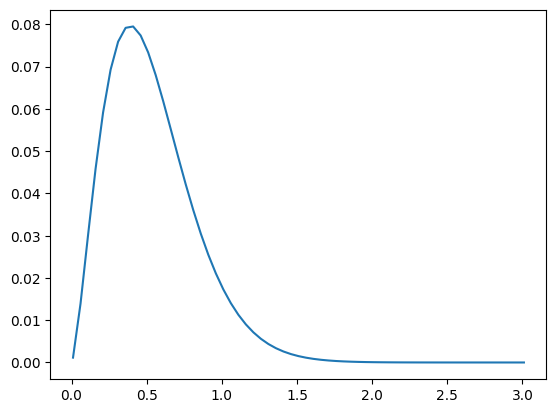

In [35]:
plt.plot(fine_z_grid, grid_prior)

Text(0, 0.5, '$P(z|T, m_{AB}(i))$')

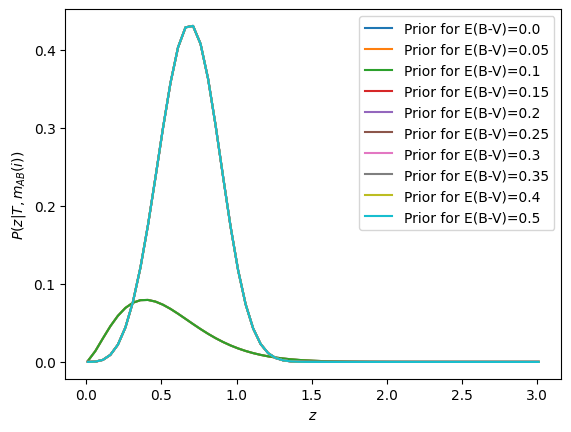

In [36]:
f,a = plt.subplots(1,1)
basetempl = baseTemp_arr[ [bt.name == df_res.loc[key_0,'Template SED'] for bt in baseTemp_arr][0] ]
extlaw = [ law for law in dust_arr if law.name==df_res.loc[key_0, 'Extinction law'] ]
obs = _obs_arr[ [_obs.num == key_0 for _obs in _obs_arr][0] ]
for law in extlaw:
    lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                            wl_grid, basetempl.flux*law.transmission)\
                              for filt in (NUV_filt, NIR_filt)])
    nuvk = lnuv-lnir
    grid_prior = vect_nz_prior(fine_z_grid, nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
    a.plot(fine_z_grid, grid_prior, label=f"Prior for E(B-V)={law.EBV}")
a.legend()
a.set_xlabel("$z$")
a.set_ylabel("$P(z|T, m_{AB}(i))$")

[DustLaw(name='Prevot', EBV=0.4, transmission=DeviceArray([0.        , 0.        , 0.        , ..., 0.9323814 ,
             0.93238825, 0.9323951 ], dtype=float32))]


Text(0, 0.5, '$P(z|T, m_{AB}(i))$')

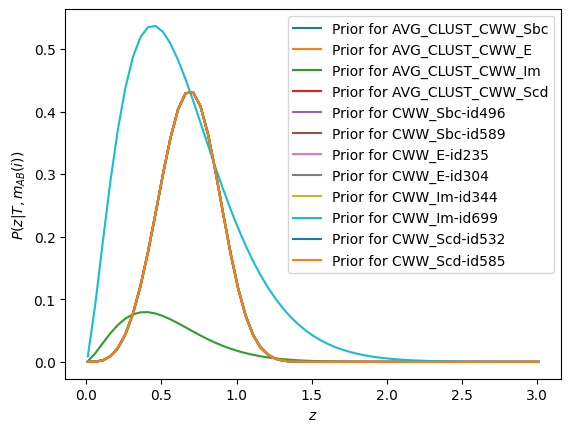

In [37]:
f,a = plt.subplots(1,1)
#basetempl = baseTemp_arr[ [bt.name == df_res.loc[key_0,'Template SED'] for bt in baseTemp_arr][0] ]
extlaw = [ law for law in dust_arr if law.name==df_res.loc[key_0, 'Extinction law'] ]
extlaw = [ law for law in extlaw if law.EBV==df_res.loc[key_0, 'E(B-V)'] ]
print(extlaw)
law=extlaw[0]
obs = _obs_arr[ [_obs.num == key_0 for _obs in _obs_arr][0] ]
for basetempl in baseTemp_arr:
    lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                            wl_grid, basetempl.flux*law.transmission)\
                              for filt in (NUV_filt, NIR_filt)])
    nuvk = lnuv-lnir
    grid_prior = vect_nz_prior(fine_z_grid, nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
    a.plot(fine_z_grid, grid_prior, label=f"Prior for {basetempl.name}")
a.legend()
a.set_xlabel("$z$")
a.set_ylabel("$P(z|T, m_{AB}(i))$")

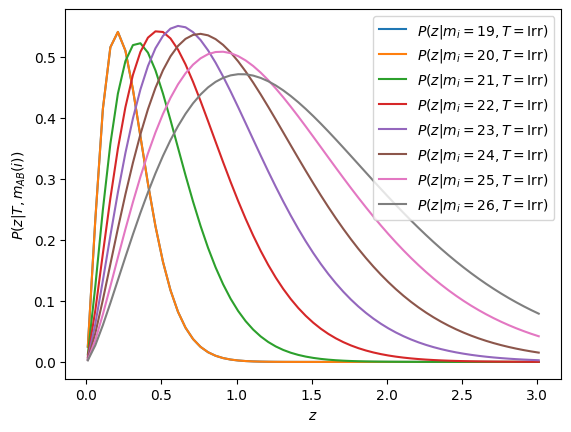

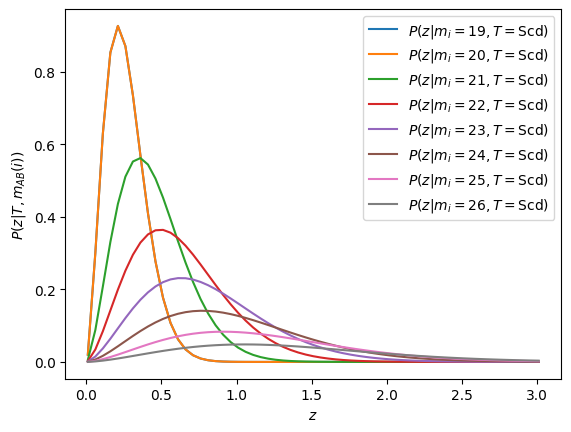

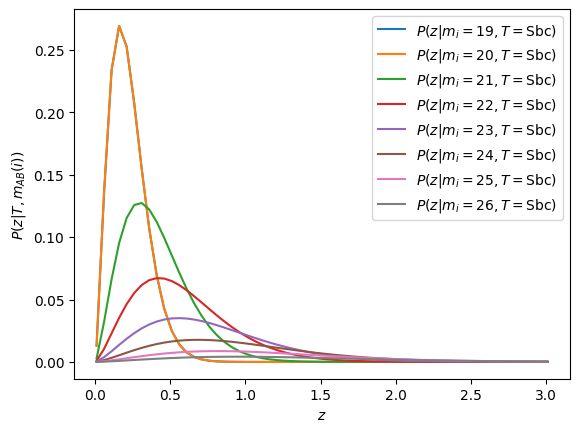

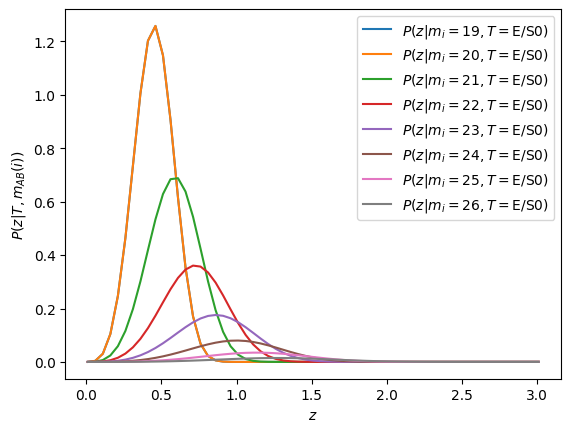

In [38]:
typNUV_dict = { 'Irr':1.5, 'Scd':2.5, 'Sbc':3.5, 'E/S0':4.5 }
for typ in typNUV_dict:
    f,a = plt.subplots(1,1)
    for magi in range(19, 27, 1):
        grid_prior = vect_nz_prior(fine_z_grid, typNUV_dict[typ], magi)
        a.plot(fine_z_grid, grid_prior, label=f"$P(z|m_i=${magi}$, T=${typ}$)$")
    a.legend()
    a.set_xlabel("$z$")
    a.set_ylabel("$P(z|T, m_{AB}(i))$")

In [39]:
PriorParams = namedtuple('PriorParams', ['mod', 'zot', 'kt', 'alpt0', 'pcal', 'nuv_range'])

prior_params_set = (PriorParams(0, 0.45181, 0.13677, 3.33078, 0.89744, (4.25, jnp.inf)),\
                    PriorParams(1, 0.16560, 0.12983, 1.42815, 0.90868, (3.19, 4.25)),\
                    PriorParams(2, 0.21072, 0.14008, 1.58310, 0.89747, (1.9, 3.19)),\
                    PriorParams(3, 0.20418, 0.13773, 1.34500, 0.91760, (-jnp.inf, 1.9)),\
                   )

prior_pars_E_S0, prior_pars_Sbc, prior_pars_Scd, prior_pars_Irr = prior_params_set

@jit
@vmap
def prior_zot(nuvk):
    val = prior_pars_Irr.zot +\
            (prior_pars_Scd.zot - prior_pars_Irr.zot)*jnp.heaviside(nuvk-prior_pars_Scd.nuv_range[0], 0)+\
            (prior_pars_Sbc.zot - prior_pars_Scd.zot)*jnp.heaviside(nuvk-prior_pars_Sbc.nuv_range[0], 0)+\
            (prior_pars_E_S0.zot - prior_pars_Sbc.zot)*jnp.heaviside(nuvk-prior_pars_E_S0.nuv_range[0], 0)
    return val

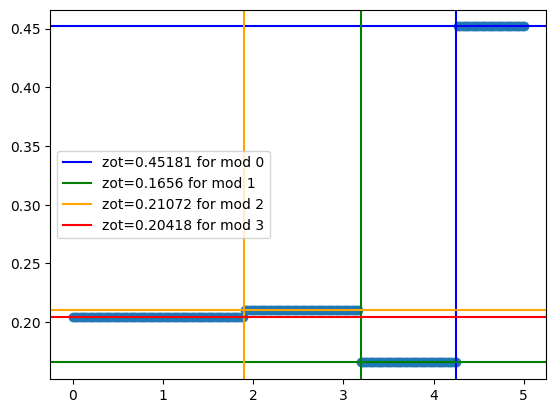

In [40]:
f,a = plt.subplots(1,1)
nuvrange = jnp.linspace(0., 5., 200)
a.scatter(nuvrange, prior_zot(nuvrange))
for pparams, cl in zip(prior_params_set, ['blue', 'green', 'orange', 'red']):
    if pparams.mod<3:
        a.axvline(pparams.nuv_range[0], c=cl)
    a.axhline(pparams.zot, c=cl, label=f"zot={pparams.zot} for mod {pparams.mod}")
a.legend()

In [41]:
val = 3.
jnp.logical_not(jnp.isfinite(val)).astype(float)*0.+jnp.isfinite(val).astype(float)*val

DeviceArray(3., dtype=float32)

/pbs/home/j/jocheval/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/pbs/home/j/jocheval/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/pbs/home/j/jocheval/.local/lib/python3.8/site-pac

Text(0.5, 0, 'Redshift z')

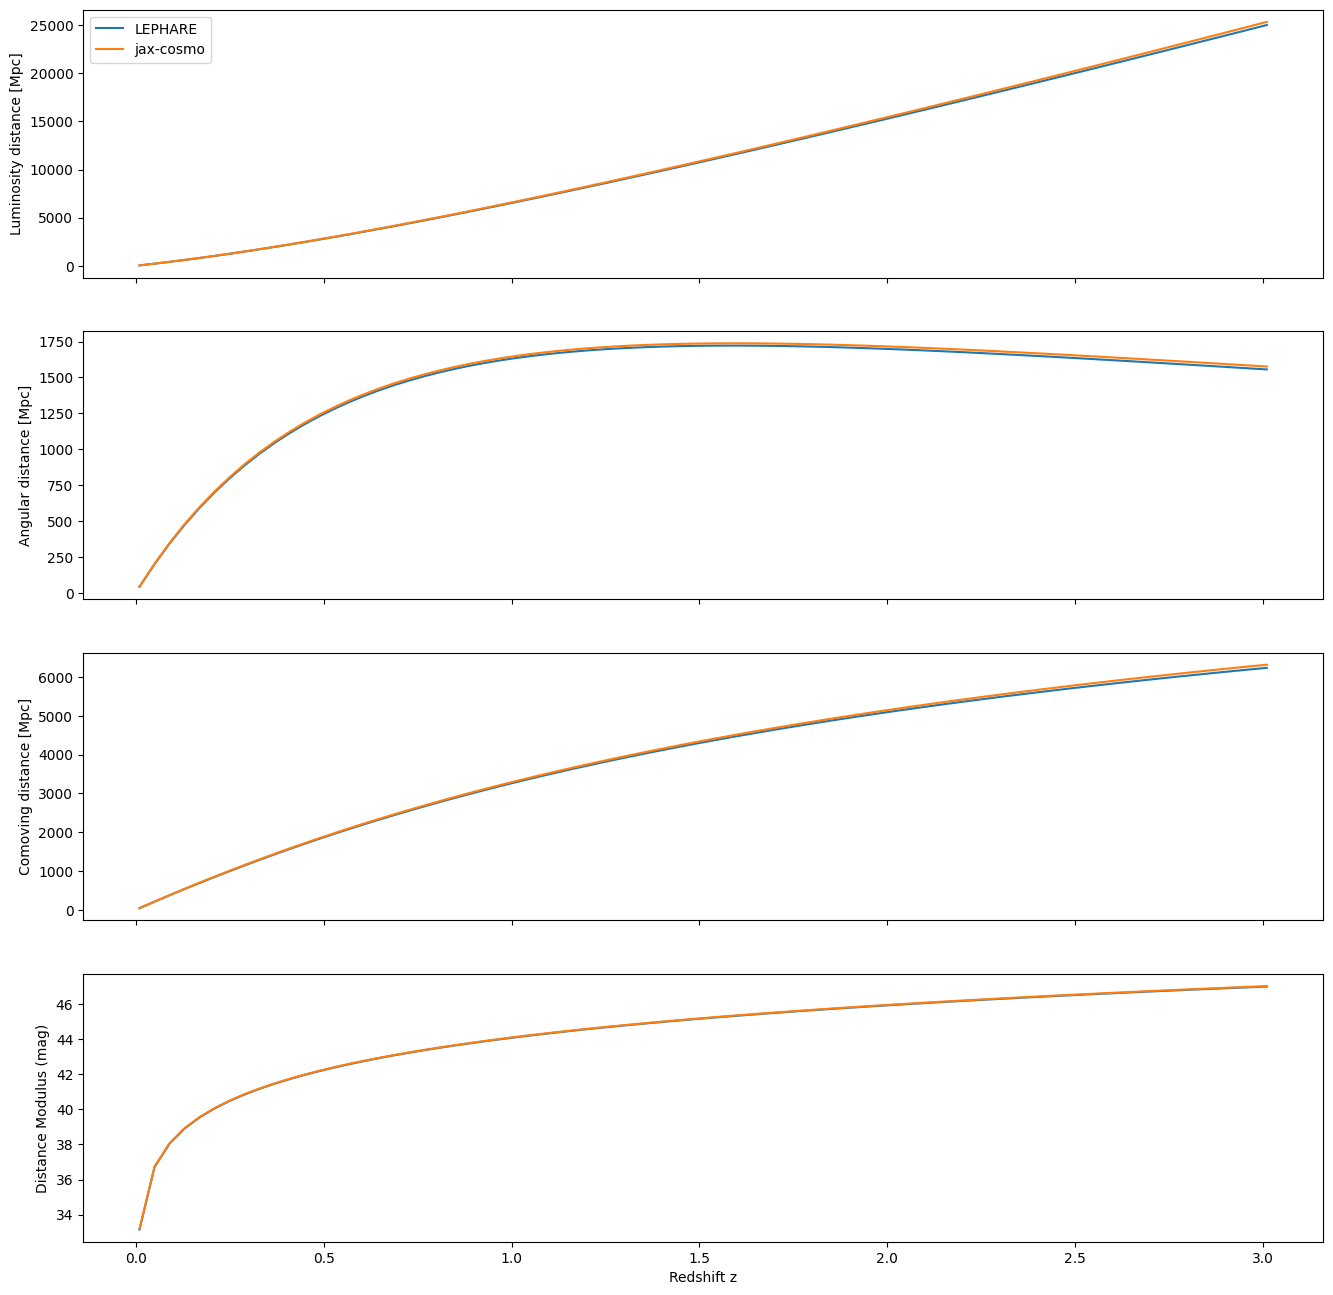

In [42]:
j_cosmo = Cosmology.make_jcosmo(inputs['Cosmology']['h0'])
a_grid = jc.utils.z2a(z_grid)

@vmap
def v_distLum(z):
    return Cosmology.distLum(cosmo, z)

@vmap
def v_distAng(z):
    return Cosmology.distAng(cosmo, z)

@vmap
def v_distMet(z):
    return Cosmology.distMet(cosmo, z)

@vmap
def v_distMod(z):
    return Cosmology.distMod(cosmo, z)


f,a = plt.subplots(4,1, figsize=(16, 16), sharex=True)
a = a.ravel()
a[0].plot(z_grid, v_distLum(z_grid), label="LEPHARE")
a[0].plot(z_grid, Cosmology.calc_distLum(j_cosmo, z_grid), label="jax-cosmo") # (1.+z_grid)*jc.background.radial_comoving_distance(j_cosmo, a_grid)/j_cosmo.h
a[0].set_ylabel('Luminosity distance [Mpc]')
a[0].legend()
a[1].plot(z_grid, v_distAng(z_grid), label="LEPHARE")
a[1].plot(z_grid, Cosmology.calc_distAng(j_cosmo, z_grid), label="jax-cosmo") # jc.background.angular_diameter_distance(j_cosmo, a_grid)/j_cosmo.h
a[1].set_ylabel('Angular distance [Mpc]')
a[2].plot(z_grid, v_distMet(z_grid), label="LEPHARE")
a[2].plot(z_grid, Cosmology.calc_distM(j_cosmo, z_grid), label="jax-cosmo")
a[2].set_ylabel('Comoving distance [Mpc]')
a[3].plot(z_grid, v_distMod(z_grid), label="LEPHARE")
a[3].plot(z_grid, Cosmology.calc_distMod(j_cosmo, z_grid), label="jax-cosmo")
a[3].set_ylabel('Distance Modulus (mag)')
a[3].set_xlabel('Redshift z')